[nltk_data] Downloading package wordnet to C:\Users\Valmik
[nltk_data]     Belgaonkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Valmik
[nltk_data]     Belgaonkar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Model Accuracy: 85.09%


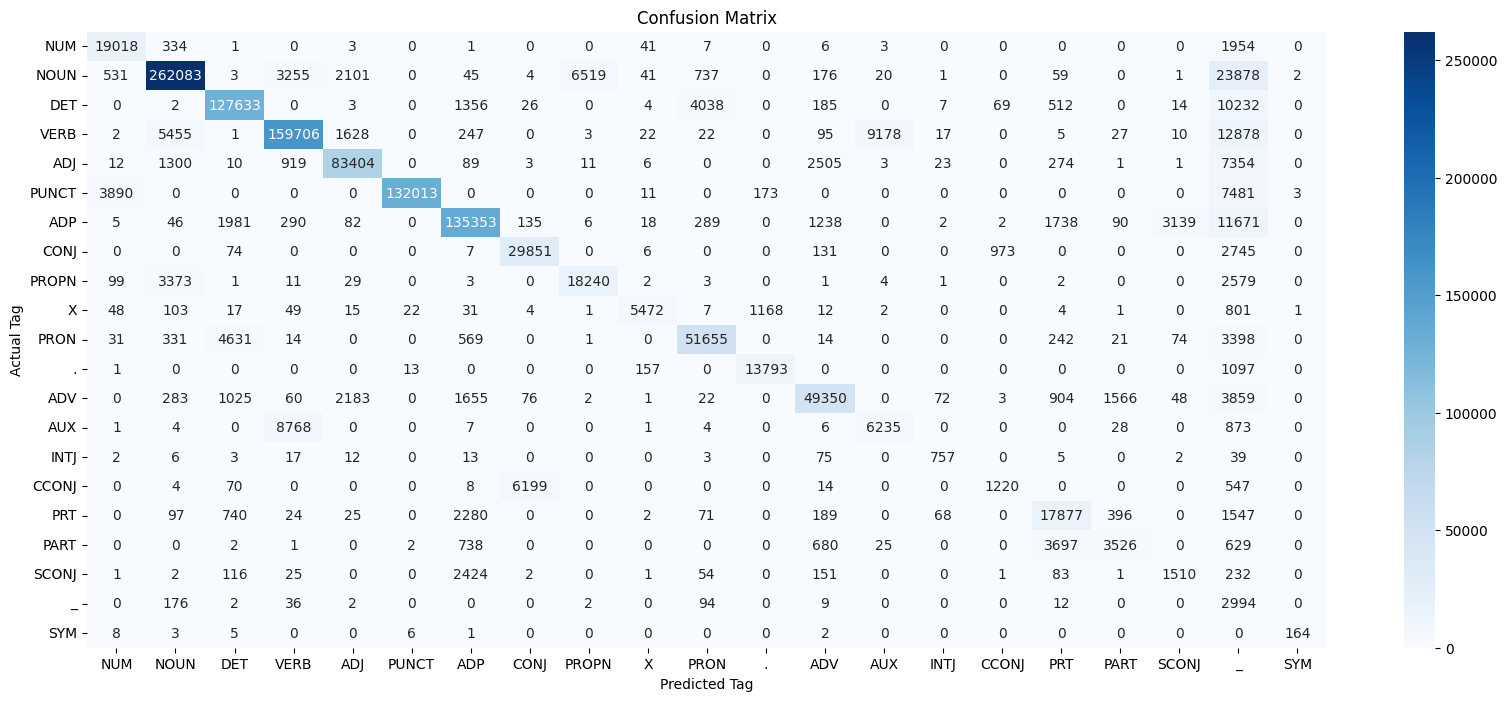

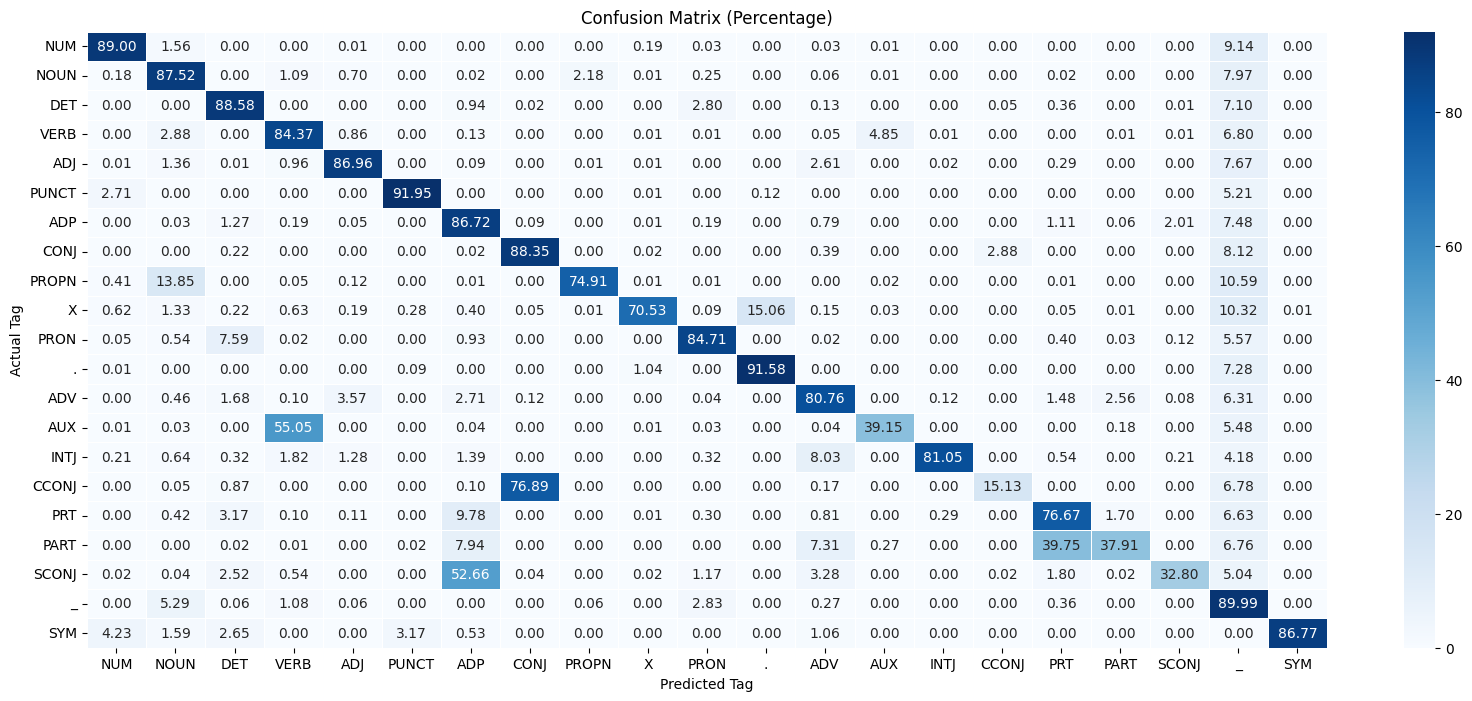

In [2]:
import pandas as pd
from collections import defaultdict
import ast
import string
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("validation_data.csv")

# Function to process each row with lemmatization
def process_text(text):
    try:
        tokens = ast.literal_eval(text)  # Convert string representation of list to actual list
        processed_tokens = [
            (word if tag in ['PRON', 'PROPN', 'NOUN'] else word.lower(), 'PUNCT' if word in string.punctuation else tag)
            for word, tag in tokens
        ]
        even_processed_tokens = [
            (lemmatizer.lemmatize(word) if tag not in ['PRON', 'PROPN', 'NOUN'] else word, 'PUNCT' if word in string.punctuation else tag)
            for word, tag in processed_tokens
        ]
        return str(even_processed_tokens)  # Convert back to string format
    except Exception as e:
        return text  # Return original if any error occurs

# Identify the column name dynamically
train_col = train_data.columns[0]
test_col = test_data.columns[0]

# Apply transformation
train_data[train_col] = train_data[train_col].apply(process_text)
test_data[test_col] = test_data[test_col].apply(process_text)

# Dictionary for tag vs count
tag_dict = defaultdict(int)
word_tag_dict = defaultdict(int)
two_tag_dict = defaultdict(int)
first_word_dict = defaultdict(int)

# Total sentence count
sentence_count = 0
for index, row in train_data.iterrows():
    sentence = row.iloc[0]
    if isinstance(sentence, str):
        try:
            sentence = ast.literal_eval(sentence)
        except (ValueError, SyntaxError):
            continue  # Skip invalid rows
    if not isinstance(sentence, list):
        continue
    
    sentence_count += 1
    if len(sentence) > 0:
        first_word_dict[(sentence[0][0], sentence[0][1])] += 1

    prev_tag = None
    for word, tag in sentence:
        word = lemmatizer.lemmatize(word)
        tag_dict[tag] += 1
        word_tag_dict[(word, tag)] += 1
        if prev_tag is not None:
            two_tag_dict[(prev_tag, tag)] += 1
        prev_tag = tag

# Initial probability calculation
initial_probability = defaultdict(int)
for key, value in first_word_dict.items():
    initial_probability[key[1]] += value
for key, value in initial_probability.items():
    initial_probability[key] = value/sentence_count

# Emission probability calculation
emission_probability = defaultdict(lambda: defaultdict(int))
for key, value in word_tag_dict.items():
    emission_probability[key[1]][key[0]] = value/tag_dict[key[1]]

# Transition probability calculation
transition_probability = defaultdict(lambda: defaultdict(int))
for key, value in two_tag_dict.items():
    transition_probability[key[0]][key[1]] = value/tag_dict[key[0]]

# Viterbi algorithm
def viterbi_algorithm(sentence:list, unique_tags:list, initial_prob:defaultdict, transition_prob:defaultdict, emission_prob:defaultdict):
    n = len(sentence)
    tags_list = list(unique_tags)
    viterbi = [{} for _ in range(n)]
    backpointer = [{} for _ in range(n)]
    for tag in tags_list:
        viterbi[0][tag] = initial_prob.get(tag, 0) * emission_prob.get(tag, {}).get(sentence[0], 0)
        backpointer[0][tag] = None
    for t in range(1, n):
        for curr_tag in tags_list:
            max_prob, best_prev_tag = max(
                (viterbi[t - 1].get(prev_tag, 0) * transition_prob.get(prev_tag, {}).get(curr_tag, 0) * emission_prob.get(curr_tag, {}).get(sentence[t], 0), prev_tag)
                for prev_tag in tags_list
            )
            viterbi[t][curr_tag] = max_prob
            backpointer[t][curr_tag] = best_prev_tag
    best_tags = []
    best_last_tag = max(tags_list, key=lambda tag: viterbi[-1].get(tag, 0))
    best_tags.append(best_last_tag)
    for t in range(n - 1, 0, -1):
        best_last_tag = backpointer[t][best_last_tag]
        best_tags.insert(0, best_last_tag)
    return best_tags

# Prepare test sentences
predicted_tags = []
actual_tags = []
validation_sentences = []
for _, row in test_data.iterrows():
    try:
        sentence = ast.literal_eval(row.iloc[0])
        if isinstance(sentence, list) and len(sentence) > 0:
            validation_sentences.append([(lemmatizer.lemmatize(word), tag) for word, tag in sentence])
    except (SyntaxError, ValueError):
        continue
if not validation_sentences:
    print("No valid test sentences found. Please check your dataset.")
    exit()
tags_list = list(tag_dict.keys())
for sentence in validation_sentences:
    words = [word for word, _ in sentence]
    if not words:
        continue
    actual_tags.extend([tag for _, tag in sentence])
    predicted_tags.extend(
        viterbi_algorithm(
            words,
            tags_list,
            initial_probability,
            transition_probability,
            emission_probability
        )
    )
accuracy = accuracy_score(actual_tags, predicted_tags)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
cm = confusion_matrix(actual_tags, predicted_tags, labels=list(tag_dict.keys()))
plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=tag_dict.keys(), yticklabels=tag_dict.keys(), cmap="Blues")
plt.xlabel("Predicted Tag")
plt.ylabel("Actual Tag")
plt.title("Confusion Matrix")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(actual_tags, predicted_tags, labels=list(tag_dict.keys()))

# Normalize by row (actual tag count)
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(20, 8))
sns.heatmap(
    cm_percentage,
    annot=True,
    fmt=".2f",
    xticklabels=list(tag_dict.keys()),
    yticklabels=list(tag_dict.keys()),
    cmap="Blues",
    linewidths=0.5
)
plt.xlabel("Predicted Tag")
plt.ylabel("Actual Tag")
plt.title("Confusion Matrix (Percentage)")
plt.show()